In [1]:
#https://www.kaggle.com/code/ptfrwrd/topic-modeling-guide-gsdm-lda-lsi

## What is the GSDMM?
Short text clustering is a challenging problem due to its sparse, high-dimensional, and large-volume characteristics. The GSDMM has the following nice properties:

GSDMM can infer the number of clusters automatically;
GSDMM has a clear way to balance the completeness and homogeneity of the clustering results;
GSDMM is fast to converge;
Unlike the Vector Space Model (VSM)-based approaches, GSDMM can cope with the sparse and highdimensional problem of short texts;
Like Topic Models (e.g., PLSA and LDA), GSDMM can also obtain the representative words of each cluster.
Let`s take a closer look at the last point (about comparing it with the most popular topic models):

In LDA, documents are considered to be a mixture of topics. Short text only deals with one topic (most of the time) so this assumption is not reliable anymore;
Shorter text means fewer data to rely on during the LDA inference steps.
Well, the Gibbs Sampling Dirichlet Mixture Model (GSDMM) is an “extended” LDA algorithm, that makes the initial assumption: 1 topic is 1 document.

The words within a document are generated using the same unique topic, and not from a mixture of topics as it was in the original LDA.

GSDMM is a good choice for short text topic modeling.

## Preprocessing the data:
The quality of our data is important for the quality of our model. I like to do preprocess with Gensim and Spacy library.

My preprocessing steps are:

removing symbols with regular expressions;
tokenization and delete punctuation;
create N-grams: bigrams and trigrams;
lemmatization;
removing stop-words.


In [2]:
import pandas as pd
import gensim
import re
import spacy
#!python -m spacy download en_core_web_sm

/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
#!pip install git+https://github.com/rwalk/gsdmm.git

In [4]:
import numpy as np 

import sys
#sys.path.append('../input/gsdmm-short-text-clustering')
from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re

from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [5]:

# Importing data
data = pd.read_excel('All interviewees responses and the corresponding representative words_withoutNONE_updatedV4.xlsx')
print(data.columns)

Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'LIWC_response', 'new_response', 'Topic most represented',
       'Topic and its most representative words'],
      dtype='object')


In [6]:

data['response_list'] = data.new_response.values.tolist()

# remove characters
data['response_list'] = [re.sub('\s+', ' ', sent) for sent in data['response_list']]
data['response_list'] = [re.sub("\'", "", sent) for sent in data['response_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [7]:
data['length'] = data.new_response.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  9.835181189076568


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

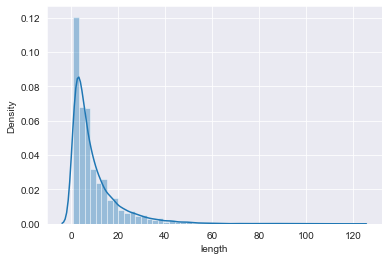

In [8]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(data['length'])

In [9]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [10]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [11]:

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'hotel', 'room', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]

In [12]:
def lemmatization(texts): # , allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc]) #  if token.pos_ in allowed_postags]
    return texts_out
# do lemmatization

In [13]:

tokens_reviews = list(sent_to_words(data['response_list']))
tokens_reviews = make_n_grams(tokens_reviews)
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews) # , allowed_postags=['NOUN', 'VERB', 'ADV']
 
# remove stop words after lemmatization
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

In [14]:
mgp = MovieGroupProcess(K=10, alpha=0.01, beta=0.01, n_iters=30)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)


In stage 0: transferred 11015 clusters with 10 clusters populated
In stage 1: transferred 8066 clusters with 10 clusters populated
In stage 2: transferred 6976 clusters with 10 clusters populated
In stage 3: transferred 6535 clusters with 10 clusters populated
In stage 4: transferred 6349 clusters with 10 clusters populated
In stage 5: transferred 6233 clusters with 10 clusters populated
In stage 6: transferred 6101 clusters with 10 clusters populated
In stage 7: transferred 5978 clusters with 10 clusters populated
In stage 8: transferred 5929 clusters with 10 clusters populated
In stage 9: transferred 5999 clusters with 10 clusters populated
In stage 10: transferred 5894 clusters with 10 clusters populated
In stage 11: transferred 5861 clusters with 10 clusters populated
In stage 12: transferred 5824 clusters with 10 clusters populated
In stage 13: transferred 5829 clusters with 10 clusters populated
In stage 14: transferred 5766 clusters with 10 clusters populated
In stage 15: transf

In [15]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))


In [26]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 15)

Number of documents per topic : [ 998 1285 1466 1006 1551  973 1498 1621 1996 1045]

Most important clusters (by number of docs inside): [8 7 4 6 2 1 9 3 0 5]

Cluster 8 : [('like', 1075), ('feel', 667), ('calm', 291), ('know', 274), ('bit', 253), ('try', 245), ('angry', 228), ('happy', 180), ('help', 154), ('probably', 134), ('happen', 133), ('way', 128), ('tell', 126), ('usually', 124), ('sure', 122)]

Cluster 7 : [('like', 1009), ('know', 296), ('teacher', 202), ('feel', 171), ('bit', 165), ('kind', 153), ('school', 153), ('people', 150), ('want', 131), ('try', 107), ('tell', 105), ('homework', 94), ('happen', 94), ('mean', 86), ('help', 85)]

Cluster 4 : [('like', 1260), ('feel', 452), ('know', 381), ('kind', 171), ('bit', 164), ('people', 147), ('want', 133), ('understand', 133), ('try', 121), ('friend', 111), ('talk', 108), ('way', 107), ('tell', 99), ('happen', 96), ('mean', 92)]

Cluster 6 : [('like', 889), ('talk', 293), ('people', 220), ('know', 216), ('try', 199), ('feel', 1

In [36]:
import pandas as pd
from collections import Counter

# get the top words for each cluster
cluster_word_distribution = mgp.cluster_word_distribution
top_words_per_cluster = []
for i in top_index:
    top_words = [word for word, count in Counter(cluster_word_distribution[i]).most_common(15)]
    top_words_per_cluster.append(top_words)

# create a DataFrame with the results
df = pd.DataFrame({
    'Cluster': top_index,
    'Top Words': top_words_per_cluster
})


In [37]:
# add the "type" string to the "Cluster" column
df['Cluster'] = df['Cluster'].map(lambda x: f"type {x}")
df['Topic']=df['Cluster']

In [39]:
df=df[['Topic','Top Words']]

In [40]:
display(df)

Topic                                          Top Words
0  type 8  [like, feel, calm, know, bit, try, angry, happ...
1  type 7  [like, know, teacher, feel, bit, kind, school,...
2  type 4  [like, feel, know, kind, bit, people, want, un...
3  type 6  [like, talk, people, know, try, feel, friend, ...
4  type 2  [like, feel, know, friend, lesson, bit, school...
5  type 1  [like, feel, know, want, angry, bit, people, c...
6  type 9  [like, friend, know, people, feel, talk, want,...
7  type 3  [like, know, want, feel, choose, option, peopl...
8  type 0  [like, know, feel, school, good, want, bit, sl...
9  type 5  [like, feel, kind, know, tell, bit, start, fri...

In [41]:
# I don`t rename the clusters

topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
               'type 7',
               'type 8',
               'type 9',
               'type 10',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [42]:
def create_topics_dataframe(data_text=data.response_list,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [43]:
result = create_topics_dataframe(data_text=data.response_list, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(5)

Text   Topic  \
0  built ready like build inside knock took like ...  type 6   
1  neither second like really like friendship gro...  type 5   
2  routine get changed like school school registr...  type 3   
3                                   like easier calm  type 1   
4  like going lying bed anything else maybe liste...  type 4   

                                          Lemma-text  
0  [build, ready, like, build, inside, knock, lik...  
1  [second, like, like, like, friend, primary, sc...  
2  [routine, change, like, school, school, regist...  
3                                 [like, easy, calm]  
4  [like, lie, bed, maybe, listen, music, watch, ...

In [44]:
print(result.shape)

(13439, 3)


In [45]:
new_result = pd.merge(result,df,on='Topic',how='left')
display(new_result.head())

Text   Topic  \
0  built ready like build inside knock took like ...  type 6   
1  neither second like really like friendship gro...  type 5   
2  routine get changed like school school registr...  type 3   
3                                   like easier calm  type 1   
4  like going lying bed anything else maybe liste...  type 4   

                                          Lemma-text  \
0  [build, ready, like, build, inside, knock, lik...   
1  [second, like, like, like, friend, primary, sc...   
2  [routine, change, like, school, school, regist...   
3                                 [like, easy, calm]   
4  [like, lie, bed, maybe, listen, music, watch, ...   

                                           Top Words  
0  [like, talk, people, know, try, feel, friend, ...  
1  [like, feel, kind, know, tell, bit, start, fri...  
2  [like, know, want, feel, choose, option, peopl...  
3  [like, feel, know, want, angry, bit, people, c...  
4  [like, feel, know, kind, bit, people, want, un...

In [46]:
new_result.to_excel('GSDMM_results.xlsx',index=False)

In [22]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [23]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [24]:
result = result.drop('Lemma-text', axis=1)

In [51]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

In [52]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

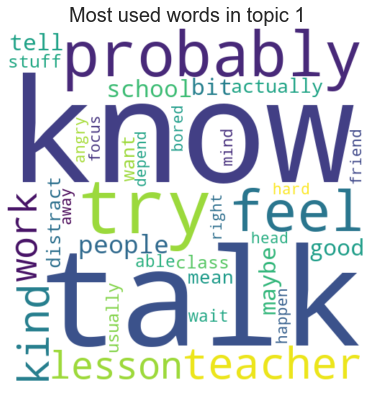

In [53]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

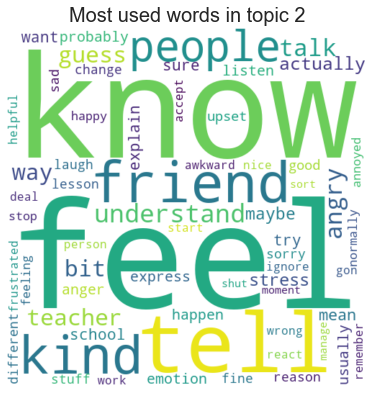

In [54]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

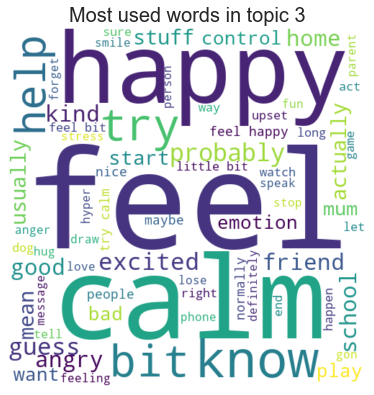

In [55]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

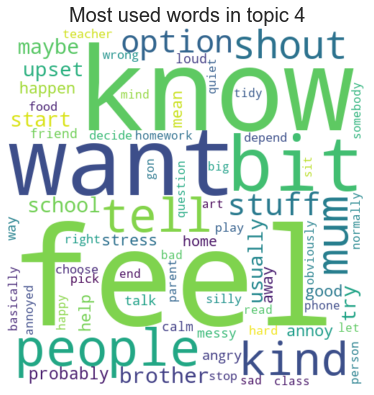

In [56]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

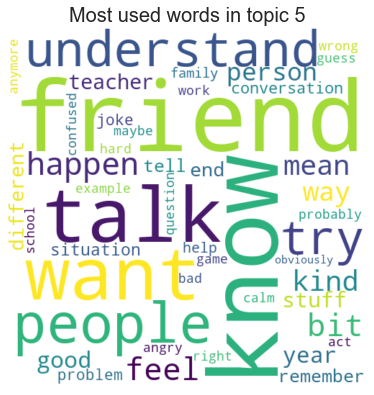

In [57]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

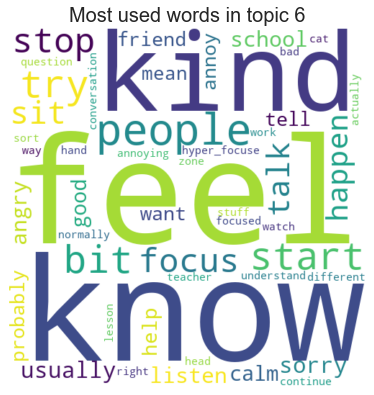

In [58]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

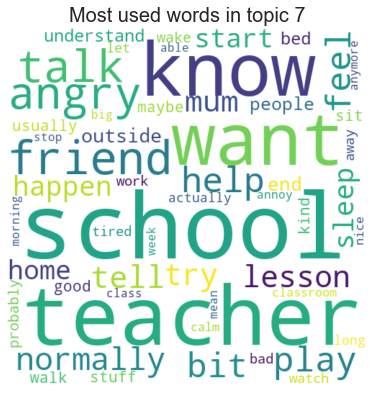

In [59]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 7'], title="Most used words in topic 7")

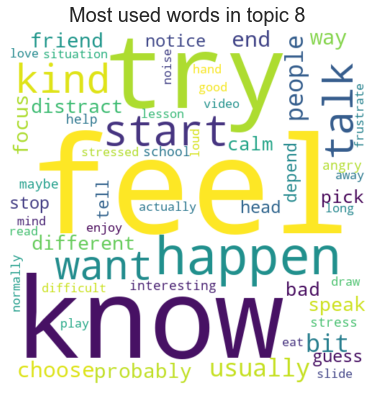

In [60]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 8'], title="Most used words in topic 8")

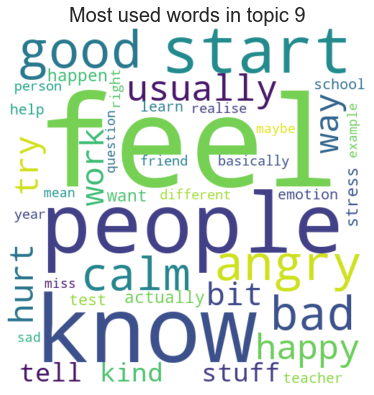

In [61]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 9'], title="Most used words in topic 9")

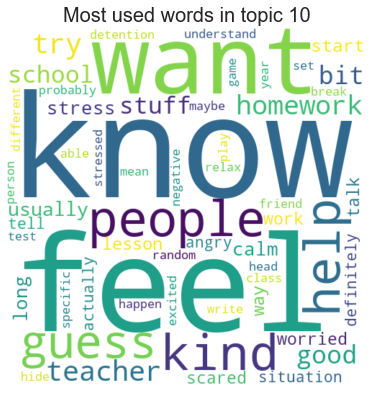

In [62]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 10'], title="Most used words in topic 10")

In [47]:
## Summary topic modeling results

In [66]:
new_data=pd.read_excel('Four topic modeling results.xlsx')
print(new_data.columns)

Index(['Topic most represented_NMF', 'topic_label_BTM', 'best_topic_STM',
       'Topic_GSDMM'],
      dtype='object')


In [72]:
nmf_groupby= new_data.groupby('Topic_GSDMM',as_index=False).count()
print(nmf_groupby)
nmf_groupby['counts'] = nmf_groupby['topic_label_BTM']

   Topic_GSDMM  Topic most represented_NMF  topic_label_BTM  best_topic_STM
0        Other                        2952             2952            2952
1       type 1                        1609             1609            1609
2      type 10                         650              650             650
3       type 2                        1538             1538            1538
4       type 3                        1387             1387            1387
5       type 4                        1221             1221            1221
6       type 5                         959              959             959
7       type 6                         842              842             842
8       type 7                         812              812             812
9       type 8                         756              756             756
10      type 9                         713              713             713


In [73]:
display(nmf_groupby[['Topic_GSDMM','counts']])


Topic_GSDMM  counts
0        Other    2952
1       type 1    1609
2      type 10     650
3       type 2    1538
4       type 3    1387
5       type 4    1221
6       type 5     959
7       type 6     842
8       type 7     812
9       type 8     756
10      type 9     713

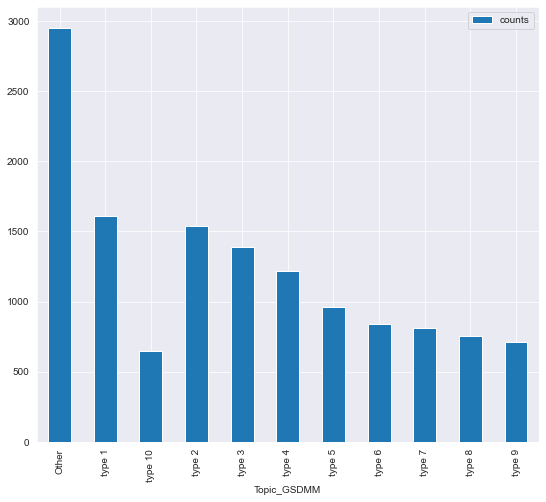

In [74]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

nmf_groupby.plot(x="Topic_GSDMM", y=["counts"], kind="bar", figsize=(9, 8))
# print bar graph
#plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.show()